### Imports ###

In [153]:
import sys
sys.path.append('/tigress/kendrab/python_pkgs')

import numpy as np
from numpy.random import rand
import pyvpic
from dataframework.src.datasets.vpicdataset import VPICDataset
from skimage import measure  # for finding contours
from skimage.segmentation import flood  # for defining structures
from skimage.morphology import binary_dilation  # for filling gaps
import scipy.ndimage as nd   # for smoothing/filtering
from scipy.spatial import Delaunay, ConvexHull
import scipy.signal as signal
import scipy.interpolate as interp
from numpy.polynomial import Polynomial

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

In [154]:
file_num = 9  # 9 so it is part of the testing dataset
files = [f'/scratch/gpfs/kendrab/dataset_vpic_runs/perturbed/21032023/output{file_num}/data.h5', None]
kwargs = {'get_vars' : ['bx', 'by', 'bz', 'jy']}
data_full = VPICDataset(vpicfiles=files, **kwargs)
wrap = True  # trying to use periodic bcs

NO PARAMS ADDED, FUNCTIONALIITY NOT ADDED YET!!!! SORRY
Added bx Variable
Added by Variable
Added bz Variable
Added jy Variable


### Function definitons ###

In [155]:
# PULL MORE STUFF OVER HERE TO STOP REPEATING SO MUCH GD CODE

In [156]:
def flatten_data(data):
    """ Flatten the data as structured in datasets to be used with an ND Interpolator from scipy"""
    if len(data.shape) == 1:  # already flat
        return data
    elif len(data.shape) == 2:  # need to flatten everything
        return data.flatten()
    elif len(data.shape) == 3:  # need second dimension to be time, first dimension has length (number of points)
        return np.column_stack(tuple(data[i].flatten() for i in range(data.shape[0])))
    else:
        raise ValueError(f"Data has unacceptable dimension {data.shape}")

In [157]:
def ccw(A,B,C):
    """ Test whether the three points are listed in a counterclockwise order, but ~vectorized~
    Can't handle colinear points because I'm not handling edge cases rn
    A- array, shape (n_pts,2)
    B- array, shape (n_pts,2)
    C- array, shape (n_pts,2)
    """
    return (C[:,1]-A[:,1])*(B[:,0] - A[:,0]) > (B[:,1] - A[:,1])*(C[:,0] - A[:,0])

def intersect_true(A, B, C, D):
    """ Determine whether two line segments AB and CD intersect
    A- array, shape (n_pts,2)
    B- array, shape (n_pts,2)
    C- array, shape (n_pts,2) (optional n_pts = 1)
    D- array, shape (n_pts,2) (optional n_pts = 1)
    """
    cond1 = np.logical_not(ccw(A, C, D) == ccw(B, C, D))
    cond2 = np.logical_not(ccw(A, B, C) == ccw(A, B, D))
    return np.logical_and(cond1, cond2)

def line_intersect(A,B,C,D):
    """ Finds the intersection of the lines AB and CD, if it exists
    Using https://en.wikipedia.org/wiki/Line%E2%80%93line_intersection#Given_two_points_on_each_line_segment
    A- array, shape (n_pts,2)
    B- array, shape (n_pts,2)
    C- array, shape (n_pts,2)
    D- array, shape (n_pts,2)
    Typically N_PTS = 1
    """
    denominator = (A[:, 0] - B[:, 0])*(C[:, 1] - D[:, 1]) - (A[:, 1] - B[:, 1])*(C[:, 0] - D[:, 0])
    px = ((A[:, 0]*B[:, 1] - A[:, 1]*B[:, 0])*(C[:, 0] - D[:, 0]) 
          - (A[:, 0] - B[:, 0])*(C[:, 0]*D[:, 1] - C[:, 1]*D[:, 0]))/denominator
    py = ((A[:, 0]*B[:, 1] - A[:, 1]*B[:, 0])*(C[:, 1] - D[:, 1]) 
          - (A[:, 1] - B[:, 1])*(C[:, 0]*D[:, 1] - C[:, 1]*D[:, 0]))/denominator
    p = np.stack([px,py], axis=1)
    return p

def in_idxs(pts, var):
    """ Checks if the indices in pts are with in the Variable var's mesh, for interpolation
    E.g. if x mesh has seven values, don't have pts at -0.5 or 6.2
    pts- array, shape (n_pts,2)
    var- variable whose mesh to use
    
    Returns:
    mask- bool array, shape (n_pts)
    """
    max0 = len(var.mesh[0])
    max1 = len(var.mesh[1])
    mask = (0 < pts[:,0] < max0) and (0 < pts[:,1] < max1)
    return mask

In [158]:
def gap_fill(array):
    """ Finds points in the 2d array that could be categorized as 'gaps' 
    And returns a mask for those points
    I'm sure there's a better way to do this but oh well"""
    
    # check if there is a pixel to the center left and a pixel in one of the the right spaces
    opp_left = np.logical_and(np.roll(array,1,axis=1), 
                            (np.abs(np.roll(array,(-1,1), axis=(1,0)))
                            + np.abs(np.roll(array,(-1,-1), axis=(1,0)))
                            + np.abs(np.roll(array,-1, axis=1))))
    # check if there is a pixel to the center right and a pixel in one of the the left spaces
    opp_right = np.logical_and(np.roll(array,-1,axis=1), 
                            (np.abs(np.roll(array,(1,-1), axis=(1,0)))
                            + np.abs(np.roll(array,(1,1), axis=(1,0)))
                            + np.abs(np.roll(array,1, axis=1))))
    # check if there is a pixel to the center top and a pixel in one of the the bottom spaces
    opp_up = np.logical_and(np.roll(array,1,axis=0), 
                            (np.abs(np.roll(array,(-1,1), axis=(0,1)))
                            + np.abs(np.roll(array,(-1,-1), axis=(0,1)))
                            + np.abs(np.roll(array,-1, axis=0))))
    # check if there is a pixel to the center bottom and a pixel in one of the the top spaces    
    opp_down = np.logical_and(np.roll(array,-1,axis=0), 
                            (np.abs(np.roll(array,(1,1), axis=(0,1)))
                            + np.abs(np.roll(array,(1,-1), axis=(0,1)))
                            + np.abs(np.roll(array,1, axis=0))))
    # check if either of the diagonals has both pixels
    opp_diag = np.logical_or(np.logical_and(np.roll(array,(1,1), axis=(0,1)), np.roll(array,(-1,-1), axis=(0,1))),
                            np.logical_and(np.roll(array,(1,-1), axis=(0,1)), np.roll(array,(-1,1), axis=(0,1))))
    
    gap_filled_array = np.logical_or.reduce((array, opp_left, opp_right, opp_up, opp_down, opp_diag))
    return gap_filled_array.astype(np.int64) #returns ones and zeros for output readability

In [159]:
def manual_anomaly_deletion(points_array, filename, time_idx):
    # points is coordinates in index units, not d_e units
    run6idx30 = (filename == '/scratch/gpfs/kendrab/dataset_vpic_runs/perturbed/21032023/output6/data.h5') and (time_idx == 30)
    run6idx30_bad = [[600, 1000],[-np.inf, np.inf]]
    modified_pt_list = []
    
    for point in points_array:        
        if run6idx30 and (run6idx30_bad[0][0] < point[0] < run6idx30_bad[0][1]) and (run6idx30_bad[1][0] < point[1] < run6idx30_bad[1][1]):
            continue # skip adding this o_point to the new list
        modified_pt_list.append(point.reshape(-1,2))
    
    new_points = np.concatenate(modified_pt_list, axis=0)
    return new_points
    

In [160]:
# # gap_fill testing
# a = np.zeros((20,20), dtype=np.int64)
# a[1,1] = 1
# a[2,3] = 1
# a[3,9] = 1
# a[5,10] = 1
# a[1,9] = 1
# a[15,10] = 1
# a[13,8] = 1
# a[13,12] = 1
# print(a)
# print(' ')
# print(gap_fill(a))

## X and O point finding ## 

In [161]:
zooms = [[-np.inf,np.inf], [-np.inf,np.inf]]
time_idx = 20 #the time index we are processing rn (testing, will be reformatted nicer someday)s
smoothing = 3

In [162]:
# copy raw data
if len(data_full.variables['bz'].data.shape) < 3:
    for key in data_full.variables.keys():
        shape2d = data_full.variables[key].data.shape
        data_full.variables[key].data = data_full.variables[key].data.reshape(1, *shape2d)
    
print(data_full.variables['bz'].data.shape)
print(data_full.timeseries)
desired_time = data_full.timeseries[time_idx]
try:
    dt = data_full.timeseries[1] - data_full.timeseries[0]
except:
    print("Attempt to calculate dt failed, assuming single time")
    dt = desired_time/2
test_dset = data_full.ndslice(timelims=[desired_time - dt/2, desired_time + dt/2], zooms=zooms)

(61, 4440, 1108)
[3.1242757e-03 9.9976826e-01 1.9995365e+00 2.9993048e+00 3.9990730e+00
 4.9988413e+00 5.9986095e+00 6.9983778e+00 7.9981461e+00 8.9979143e+00
 9.9976826e+00 1.0997451e+01 1.1997219e+01 1.2996987e+01 1.3996756e+01
 1.4996524e+01 1.5996292e+01 1.6996059e+01 1.7995829e+01 1.8995598e+01
 1.9995365e+01 2.0995132e+01 2.1994902e+01 2.2994671e+01 2.3994438e+01
 2.4994205e+01 2.5993975e+01 2.6993744e+01 2.7993511e+01 2.8993279e+01
 2.9993048e+01 3.0992817e+01 3.1992584e+01 3.2992352e+01 3.3992119e+01
 3.4991890e+01 3.5991657e+01 3.6991425e+01 3.7991196e+01 3.8990963e+01
 3.9990730e+01 4.0990498e+01 4.1990265e+01 4.2990036e+01 4.3989803e+01
 4.4989571e+01 4.5989342e+01 4.6989109e+01 4.7988876e+01 4.8988644e+01
 4.9988411e+01 5.0988182e+01 5.1987949e+01 5.2987717e+01 5.3987488e+01
 5.4987255e+01 5.5987022e+01 5.6986790e+01 5.7986557e+01 5.8986328e+01
 5.9986095e+01]


### Smoothing Bx and Bz ###

In [163]:
 # try gaussian filtering in space
data_full.variables['bx'].data = nd.gaussian_filter(data_full.variables['bx'].data,[0,smoothing, smoothing]) 
data_full.variables['bz'].data = nd.gaussian_filter(data_full.variables['bz'].data,[0,smoothing, smoothing])

### 0 contours of Bx and Bz, zoomed in ###

In [164]:
bx = data_full.variables['bx'].ndslice(zooms=zooms)
bz = data_full.variables['bz'].ndslice(zooms=zooms)
jy = data_full.variables['jy'].ndslice(zooms=zooms)
smooth_bx_data = bx.data[time_idx] 
smooth_bz_data = bz.data[time_idx]

dbx_dz, dbx_dx = np.gradient(smooth_bx_data, *bx.mesh)
dbz_dz, dbz_dx = np.gradient(smooth_bz_data, *bz.mesh)
fluxfn_hessian_det = dbz_dx*(-dbx_dz) - (-dbx_dx)*dbz_dz
topology = np.sign(fluxfn_hessian_det)  # 1 for max or min, -1 for saddle

dz_per_de = 1/(bz.mesh[0][1]-bz.mesh[0][0])
dx_per_de = 1/(bz.mesh[1][1]-bz.mesh[1][0])
d_per_de = int((dz_per_de + dx_per_de)/2)
print("Approximate number of grid spacings per 1 de:", d_per_de)


Approximate number of grid spacings per 1 de: 4


### Calculating flux function ###

In [165]:
data_full.calc_fluxfn(b1_name='bz', b2_name='bx')
# TODO: make sure you don't have a sign error in the flux function

Added flux_fn Variable


### show those flux contours ###

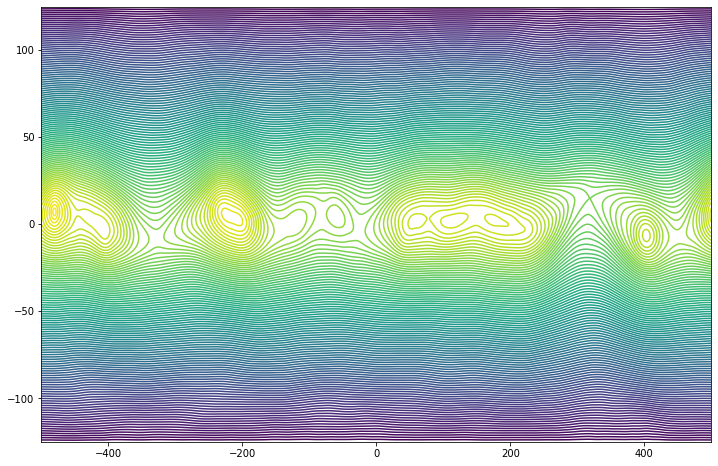

In [166]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl

flux_fn_zoomed = nd.gaussian_filter(data_full.variables['flux_fn'].ndslice(zooms=zooms).data[time_idx],[smoothing, smoothing]) 
X,Y = np.meshgrid(*bx.mesh, indexing='ij')
fig, ax = plt.subplots(figsize=(12,8))
ctr =ax.contour(X,Y,flux_fn_zoomed, levels=100)

248 1


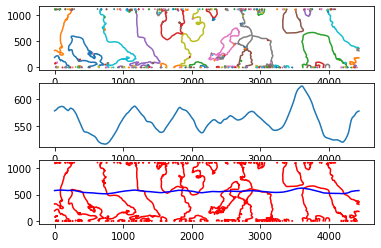

In [167]:
# Contour finding using skimage.measure.find_contours
zeros_bx = measure.find_contours(smooth_bx_data,0)  # this alg uses LINEAR interpolation, so we will too
zeros_bz = measure.find_contours(smooth_bz_data,0)
# Plot to visualize
print(len(zeros_bx), len(zeros_bz))
fig2, ax2 = plt.subplots(3)
for contour in zeros_bx:
    ax2[0].plot(contour[:,0],contour[:,1])
    ax2[2].plot(contour[:,0],contour[:,1], color='r')
for contour in zeros_bz:
    ax2[1].plot(contour[:,0],contour[:,1])
    ax2[2].plot(contour[:,0],contour[:,1], color='b')

### Setting up dictionary to hold interpolators of key things ###

In [168]:
default_meshgrid = np.meshgrid(*bx.mesh, indexing='ij')  # needed for LinearNDInterpolator
#idx_meshgrid = np.mgrid[0:bx.shape[0], 0:bx.shape[1]]
#all_idxs = np.column_stack(tuple(idx_meshgrid[i].flatten() for i in range(len(idx_meshgrid))))
#all_pts = np.column_stack(tuple(default_meshgrid[i].flatten() for i in range(len(default_meshgrid))))
all_pts = np.stack(default_meshgrid, axis=2) # smush together for interpolating as the data
interps = {}
idx_mesh = (np.array(range(len(bx.mesh[0]))), np.array(range(len(bx.mesh[1]))))
interps['all_pts'] = interp.RegularGridInterpolator(idx_mesh, all_pts)
interps['fluxfn_hessian_det'] = interp.RegularGridInterpolator(idx_mesh, fluxfn_hessian_det)
interps['flux_fn'] = interp.RegularGridInterpolator(idx_mesh, flux_fn_zoomed)
interps['jy'] = interp.RegularGridInterpolator(idx_mesh, jy.data[time_idx])
if wrap == True:
    idx_mesh = (np.array(range(3*len(bx.mesh[0]))), np.array(range(len(bx.mesh[1]))))
    x_span = bx.mesh[0][-1] - bx.mesh[0][0]
    x_coords = np.stack([np.ones_like(default_meshgrid[0]), np.zeros_like(default_meshgrid[0])], axis=2)
    all_pts = np.concatenate([all_pts - x_span*x_coords, all_pts, all_pts + x_span*x_coords], axis=0)
    interps['all_pts'] = interp.RegularGridInterpolator(idx_mesh, all_pts)
    wrapped_flux_fn = np.tile(flux_fn_zoomed,(3,1))
    interps['flux_fn'] = interp.RegularGridInterpolator(idx_mesh, wrapped_flux_fn, bounds_error=False, fill_value=None)

### Finding intersections of 0 contours ###

In [169]:
# each contour is an m x 2 array for m some other number depending on the number of points in the contour
# break up each contour into m-1 line segments and check if they intersect each other
nulls_list = []
for contour_x in zeros_bx:  # sigh there probably isn't a better way to do this
    endpt_x_1 = contour_x[:-1]
    endpt_x_2 = contour_x[1:]
    for contour_z in zeros_bz:
        endpt_z_1 = contour_z[:-1]
        endpt_z_2 = contour_z[1:]
        for i in range(endpt_x_1.shape[0]):  # check if the x contour line segments intersect any of the z contour ones
            endpt_x_1i = endpt_x_1[i].reshape(-1,2)
            endpt_x_2i = endpt_x_2[i].reshape(-1,2)
            intersects = np.nonzero(intersect_true(endpt_z_1, endpt_z_2, endpt_x_1i, endpt_x_2i))[0]  # get indices of contour_x which intercept
            if len(intersects) != 0:  # only add in points that exist
                intersect_pt = line_intersect(endpt_z_1[intersects], endpt_z_2[intersects], endpt_x_1i, endpt_x_2i)
                nulls_list.append(intersect_pt)  # DO NOT round intersections to nearest integer
        
nulls = np.concatenate(nulls_list, axis=0)
m_nulls = tuple(np.sign(interps['fluxfn_hessian_det'](nulls[i]))[0] == -1 
                for i in range(nulls.shape[0]))  # need to put this here to account for changing topo later
p_nulls = tuple(np.sign(interps['fluxfn_hessian_det'](nulls[i]))[0] == 1
                for i in range(nulls.shape[0]))

ax2[2].scatter(nulls[m_nulls,0], nulls[m_nulls,1], color='black', marker='$m$')
ax2[2].scatter(nulls[p_nulls,0], nulls[p_nulls,1], color='black', marker='$p$')
print(len(nulls))

20


### Reducing the null points to their clusters and reducing each of those to their median value ###

In [170]:
blobs = []  # will hold numpy arrays, each array the coordinates of one 'blob' of nulls
adj_idxs = []
""" DON'T USE, OUTDATED!!! NOT GOOD WITH LINEAR INTERPOLATION !!!!"""
""" Combine the numerically adjacent nulls""" # NOT NEEDED if sufficiently smooth 
for new_coord in nulls:  # iterates along the first coordinate, yay
    adj_idxs = []  # holds indices of null coordinates directly adjacent to new_coord
    for i, blob in enumerate(blobs): 
        for coord in blob:  # check if new_coord is adjacent to coord in blob
            diff = coord - new_coord
            if (np.linalg.norm(diff) < 0.5  # make note of adjacent blob (adj. points probably numerical issue)
                and np.sign(interps['fluxfn_hessian_det'](coord)) == 
                np.sign(interps['fluxfn_hessian_det'](new_coord))):  # see if both O or X-points, to combine
                adj_idxs.append(i)                                                    
                break  # don't want to append i multiple times if it touches multiple coords in a blob  
    if len(adj_idxs) > 1:  # adjacent to more than one blob- need to combine blobs!
        big_blob = [new_coord.reshape(-1,2)]
        for idx in adj_idxs:
            big_blob.append(blobs[idx])  # making up the new big blob
        np.delete(np.array(blobs, dtype=object), adj_idxs).tolist()
        big_blob_arr = np.concatenate(big_blob)
        blobs.append(big_blob_arr)
    elif len(adj_idxs) == 0:  # not adjacent to any existing blob, makes new blob
        blobs.append(new_coord.reshape(-1,2))
    elif len(adj_idxs) == 1:  # adjacent to exactly one blob
        blobs[adj_idxs[0]] = np.concatenate((blobs[adj_idxs[0]], new_coord.reshape(-1,2)), axis=0)
    else:
        print(f"bad size of adj_coords {len(adj_idxs)}")
print(f"Number of nulls after numerical combination: {len(blobs)}")

""" Combine physically adjacent blobs, with topology cancellation"""
for i in range(len(blobs)): 
    for j in range(i+1, len(blobs)):  # no repeats thank you very much
        adjacent = False
        for coord_i in blobs[i]:
            for coord_j in blobs[j]:  # ewwwwwwwww please make this less awful
                diff = coord_j - coord_i
                if (np.linalg.norm(diff) < 0):  # blobs are touching
                    adjacent = True
                    break
            if adjacent:  # already know blobs i and j are touching
                break
        if adjacent:  # combine the blobs and update the topology
            new_topology = (np.sign(interps['fluxfn_hessian_det'](blobs[i][0]))[0] 
                            + np.sign(interps['fluxfn_hessian_det'](blobs[j][0]))[0])
            blobs[i] = np.concatenate([blobs[i], blobs[j]])  # pool all the touching blob points into the first blob
            blobs[j] = []  # second blob is redundant now but don't want to mess up for loop
trimmed_blobs = list(blob for blob in blobs if not len(blob) == 0)  # get rid of redundant empty blobs   
print("Number of nulls after physical combination:", len(trimmed_blobs))
for i, blob in enumerate(trimmed_blobs): #take integer version of the average value and have that be the center for now
    avg_place = np.average(blob, axis=0)
    closest_idx = np.argmin(np.sum((blob - avg_place)**2, axis=1))
    trimmed_blobs[i] = blob[closest_idx].reshape(-1,2)  # update list

blobs_arr = np.concatenate(trimmed_blobs)

Number of nulls after numerical combination: 20
Number of nulls after physical combination: 20


### Separating X and O points ###

In [171]:
o_idxs = [np.sign(interps['fluxfn_hessian_det'](blobs_arr[i])[0]) == 1 for i in range(blobs_arr.shape[0])]
x_idxs = [np.sign(interps['fluxfn_hessian_det'](blobs_arr[i])[0]) == -1 for i in range(blobs_arr.shape[0])]
inconcl_idxs = [np.sign(interps['fluxfn_hessian_det'](blobs_arr[i])[0]) == 0 for i in range(blobs_arr.shape[0])]
o_coords = blobs_arr[o_idxs]
x_coords = blobs_arr[x_idxs]
inconcl_coords = blobs_arr[inconcl_idxs]
other_coords = blobs_arr[np.logical_not(np.logical_or.reduce((o_idxs, x_idxs, inconcl_idxs)))]

print(o_coords.shape)
print(x_coords.shape)
print(inconcl_coords.shape)
print(other_coords.shape)
print(np.max(np.abs(o_coords - nulls[p_nulls,:])))
print(max(idx_mesh[0]), max(idx_mesh[1]))

(10, 2)
(10, 2)
(0, 2)
(0, 2)
0.0
13319 1107


### Plot X and O points on flux contour ###


In [172]:
# PLEASE throw these into a function or something, this is nasty :(
ax.scatter(*interps['all_pts'](nulls[m_nulls,:]).T, marker='$m$', color='black')
ax.scatter(*interps['all_pts'](nulls[p_nulls,:]).T, marker='$p$', color='black')
X_opts = interps['all_pts'](o_coords)[:,0]
Y_opts = interps['all_pts'](o_coords)[:, 1]
X_xpts = interps['all_pts'](x_coords)[:, 0]
Y_xpts = interps['all_pts'](x_coords)[:, 1]
X_inconclpts = interps['all_pts'](inconcl_coords)[:, 0]
Y_inconclpts = interps['all_pts'](inconcl_coords)[:, 1]
X_otherpts = interps['all_pts'](other_coords)[:, 0]
Y_otherpts = interps['all_pts'](other_coords)[:, 1]
if wrap == True:
    x_span = bx.mesh[0][-1] - bx.mesh[0][0]
    X_opts += x_span
    X_xpts += x_span
    X_inconclpts += x_span
    X_otherpts += x_span
ax.scatter(X_opts, Y_opts, marker='o', facecolor='none', edgecolors='r')
ax.scatter(X_xpts, Y_xpts, color='r', marker='x')
ax.scatter(X_inconclpts, Y_inconclpts, color='r', marker='_')
ax.scatter(X_otherpts, Y_otherpts, color='r', marker='$?$')
plt.show()

## Designating regions around X and O points, testing ##

### Look at plots with topology / flux function hessian ###

In [173]:
# value_range = [np.quantile(fluxfn_hessian_det, .01, interpolation='midpoint'),
#               np.quantile(fluxfn_hessian_det, .99, interpolation='midpoint')]
# fluxfn_hessian_det_nulls = [fluxfn_hessian_det[tuple(blobs_arr[i])] for i in range(blobs_arr.shape[0])]

# figtest, axtest = plt.subplots(2, figsize=(8, 6))
# axtest[0].imshow(topology.T, aspect='auto', interpolation='none')
# hess_img = axtest[1].imshow(fluxfn_hessian_det.T, aspect='auto', interpolation='none', vmin=value_range[0],
#                 vmax = value_range[1])
# figtest.colorbar(hess_img)
# for axes in axtest:
#     axes.scatter(o_coords[:,0], o_coords[:,1], color='r', marker='o')
#     axes.scatter(x_coords[:,0], x_coords[:,1], color='r', marker='x')

### Try constant flux contours from x points and overplot w/ B, current density ###

In [174]:
o_coords = manual_anomaly_deletion(o_coords, files[0], time_idx)  # gotta just do this sometimes I guess

if wrap == True: # also extend x coords and o coords pls
    orig_len = flux_fn_zoomed.shape[0]
    which_coord = np.array([1,0])
    flux_fn_zoomed = np.tile(flux_fn_zoomed,(3,1))
    x_coords = np.concatenate([x_coords, x_coords+orig_len*which_coord, x_coords+2*orig_len*which_coord], axis=0)
    o_coords = np.concatenate([o_coords, o_coords+orig_len*which_coord, o_coords+2*orig_len*which_coord], axis=0)

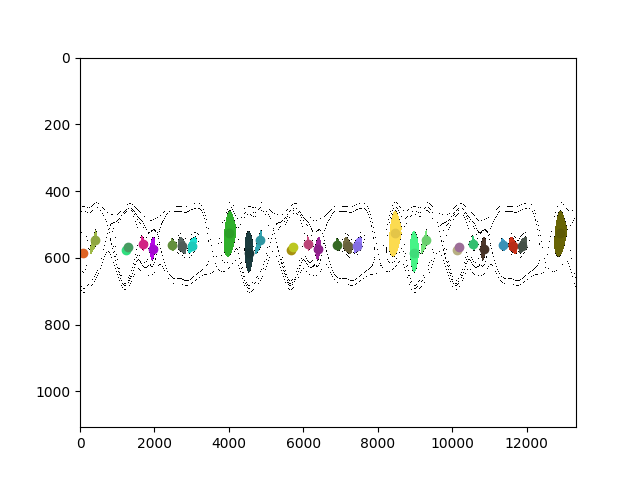

In [175]:
%matplotlib widget
tol = 7 #number of de to be close to
boundaries = []
smooth_jy = nd.gaussian_filter(data_full.variables['jy'].data[time_idx],[smoothing, smoothing])

bound_mask = np.zeros_like(flux_fn_zoomed)
xpt_mask = np.zeros_like(bound_mask)

for i in range(x_coords.shape[0]):  # I love nested for loops...
    xline_contours = measure.find_contours(flux_fn_zoomed, 
                                           level=interps['flux_fn'](x_coords[i]))
    xpt_idxs = np.indices(xpt_mask.shape)
    this_x = np.where(np.sqrt((xpt_idxs[0] - x_coords[i][0])**2 + (xpt_idxs[1] - x_coords[i][1])**2) < tol*d_per_de, 1, 0)
    xpt_mask = np.logical_or(xpt_mask, this_x)
    local_contours = []
    for contour in xline_contours:
#        print(contour.shape[0])
        if contour.shape[0] > 150:  # no little blips please
            if min(np.linalg.norm(contour - x_coords[i], axis=1)) <= d_per_de*tol:
                local_contours.append(contour)
    # find_contours returns list, let's make a list of lists
    boundaries.append(local_contours)


# fig_j, ax_j = plt.subplots(2)    
# img = ax_j[0].imshow(jy.data[time_idx].T, aspect='auto', interpolation='none')
# img2 = ax_j[1].imshow(jy.data[time_idx].T, aspect='auto', interpolation='none', vmin = -0.1, vmax=0.00)
# fig_j.colorbar(img2)



for i, level in enumerate(boundaries):
    for contour in level:
        bdy_points = interps['all_pts'](contour)
        ax.plot(bdy_points[:,0], bdy_points[:,1], linestyle='dashed')
#        ax_j[0].plot(contour[:,0], contour[:,1])
#        ax_j[1].plot(contour[:,0], contour[:,1])
        
        #make a mask that should in theory show where the boundaries are (pixel by pixel)
        for point in contour:
            bound_mask[tuple(point.astype(np.int64))] = 1
# fill in potential gaps in the contours
bound_mask_filled = gap_fill(bound_mask)
            
fig_bdy, ax_bdy = plt.subplots()
img_bdy = ax_bdy.imshow(bound_mask_filled.T, aspect='auto', interpolation='none', cmap=plt.get_cmap('binary'))

all_structures = np.zeros_like(bound_mask)

for i,coord in enumerate(o_coords):
    color = rand(3)
    if bound_mask_filled[tuple(coord.astype(np.int64))] == 0:
        structure = flood(bound_mask_filled, tuple(coord.astype(np.int64)), connectivity=1)
        if (np.all(structure[0,:] == 0) and np.all(structure[-1,:] == 0) 
            and np.all(structure[:,0] == 0) and np.all(structure[:,-1] == 0)):
            structure = np.logical_and(structure,np.logical_not(xpt_mask))  # exclude x points from structure
            all_structures = np.logical_or(all_structures, structure).astype(np.int64)
            struct_pic = np.stack([structure.T*color[0], structure.T*color[1], structure.T*color[2], structure.T], axis=2)
            ax_bdy.imshow(struct_pic, aspect='auto', interpolation='none')
    ax_bdy.plot(coord[0],coord[1], 'o', color=color*0.9)


In [176]:
if wrap==True:
    orig_len = all_structures.shape[0]//3
    print(orig_len)
    all_structures = all_structures[orig_len:2*orig_len,:]
    flux_fn_zoomed = flux_fn_zoomed[orig_len:2*orig_len,:]

4440


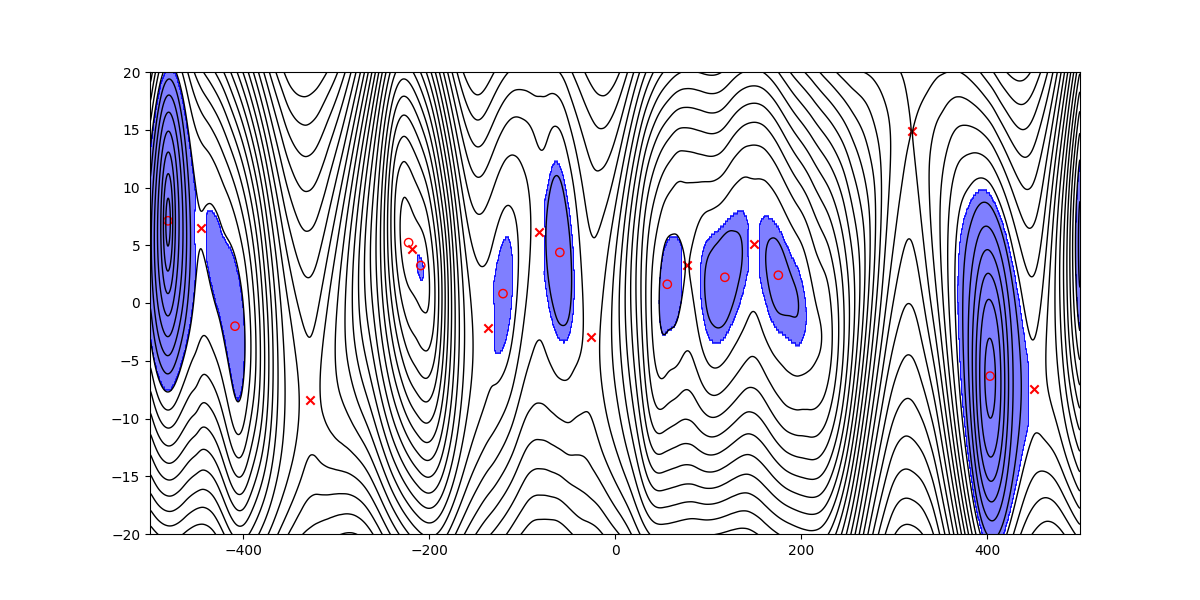

In [177]:
fig_structs, ax_structs = plt.subplots(figsize=(12,6))
ax_structs.contourf(*default_meshgrid, all_structures, alpha=0.5, cmap = mpl.colors.ListedColormap(['white', 'blue']))
ax_structs.contour(*default_meshgrid, flux_fn_zoomed, levels=100, colors='black', linewidths=1)
ax_structs.scatter(X_opts, Y_opts, marker='o', facecolor='none', edgecolors='r')
ax_structs.scatter(X_xpts, Y_xpts, color='r', marker='x')
ax_structs.scatter(X_inconclpts, Y_inconclpts, color='r', marker='_')
ax_structs.scatter(X_otherpts, Y_otherpts, color='r', marker='$?$')
ax_structs.set(ylim=[-20,20])
plt.show()

### Try using constant flux contours, but get each whole O structure

In [178]:
# separatrices_mask = np.zeros_like(flux_fn_zoomed)
# o_structs_mask = np.zeros_like(flux_fn_zoomed)
# struct_pics = []

# rng = np.random.default_rng(125)
# fig_bdy2, ax_bdy2 = plt.subplots()

# for i in range(x_coords.shape[0]):  # I love nested for loops...
#     xline_contours = measure.find_contours(flux_fn_zoomed, 
#                                            level=interps['flux_fn'](x_coords[i]))
#     xpt_mask = np.zeros_like(flux_fn_zoomed)
#     xpt_mask[tuple(x_coords[i].astype(np.int64))] = 1
#     xpt_mask = binary_dilation(xpt_mask).astype(np.int64)
#     local_separatrices = np.zeros_like(flux_fn_zoomed)
#     local_separatrices = np.logical_or(local_separatrices, xpt_mask)
#     for contour in xline_contours:
#         if min(np.linalg.norm(contour - x_coords[i], axis=1)) <= d_per_de*tol:
#             bdy_points = interps['all_pts'](contour)
#             ax.plot(bdy_points[:,0], bdy_points[:,1], linestyle='dashed')
#             for point in contour:  # add to the mask
#                 local_separatrices[tuple(point.astype(np.int64))] = 1


#     # fill in potential gaps in the contours
#     local_separatrices_filled = gap_fill(local_separatrices)
#     separatrices_mask = np.logical_or(separatrices_mask, local_separatrices_filled)    
    
#     while np.sum(local_separatrices_filled == 0) > 0:  # fill in all the sections according to their geometry
#         # select a random 0-valued point
#         indices = np.nonzero(local_separatrices_filled == 0)
#         random_int = rng.integers(len(indices[0]))
#         random_idx = (indices[0][random_int], indices[1][random_int])
#         structure_candidate = flood(local_separatrices_filled, random_idx, connectivity=1)
#         local_separatrices_filled +=  -1*structure_candidate  # set these regions as investigated already
#         if (np.all(structure_candidate[0,:] == 0) and np.all(structure_candidate[-1,:] == 0)  # doesn't intersect boundary
#             and np.all(structure_candidate[:,0] == 0) and np.all(structure_candidate[:,-1] == 0)):
#             o_structs_mask = np.logical_or(o_structs_mask, structure_candidate).astype(np.int64)
#             color=rng.random(3)
#             struct_pic = np.stack([structure_candidate.T*color[0], structure_candidate.T*color[1],
#                                    structure_candidate.T*color[2], structure_candidate.T], axis=2)
#             struct_pics.append(struct_pic)
            
            
# img_bdy2 = ax_bdy2.imshow(separatrices_mask.T, aspect='auto', interpolation='none', cmap=plt.get_cmap('binary'))  
# for struct_pic in struct_pics:
#     ax_bdy2.imshow(struct_pic, aspect='auto', interpolation='none')
    
# for coord in o_coords:
#     ax_bdy2.plot(coord[0],coord[1], 'o', color='gray')

# plt.show()
    


### Try Current sheet IDing ###

In [179]:
# cs_maxes = nd.maximum_filter(smooth_jy, size=(10, 10))
# cs_mins = nd.minimum_filter(smooth_jy, size=(10, 10))
# max_thresh = cs_maxes.mean() + cs_maxes.std() * 3
# min_thresh = cs_mins.mean() - cs_mins.std() * 3

# # find areas greater/less than threshold value
# max_labels, max_num = nd.label(cs_maxes > max_thresh)
# min_labels, min_num = nd.label(cs_mins < min_thresh)
# # Get the positions of the extrema
# max_coords = nd.maximum_position(smooth_jy, labels=max_labels, index=np.arange(1, max_num + 1))
# min_coords = nd.minimum_position(smooth_jy, labels=min_labels, index=np.arange(1, min_num + 1))
# # Get the extrema values
# max_values = nd.maximum(smooth_jy, labels=max_labels, index=np.arange(1, max_num + 1))
# min_values = nd.minimum(smooth_jy, labels=min_labels, index=np.arange(1, min_num + 1))

# cs_loc_pos = np.zeros_like(smooth_jy)
# cs_loc_neg = np.zeros_like(smooth_jy)

# cs_limit = 0.5
# for i in range(max_num):
#     # mask cs values which are "high enough"
#     cs_pos = smooth_jy > max_values[i]*cs_limit
#     # keep only cs which are local to the sheet
#     cs_pos = flood(cs_pos, max_coords[i], connectivity=1)
#     # update mask of all positive current sheets
#     cs_loc_pos = np.logical_or(cs_loc_pos, cs_pos)
    
# for i in range(min_num):
#     # mask cs values which are "low enough"
#     cs_neg = smooth_jy < min_values[i]*.5
#     # keep only cs which are local to the sheet
#     cs_neg = flood(cs_neg, min_coords[i], connectivity=1)
#     # update mask of all positive current sheets
#     cs_loc_neg = np.logical_or(cs_loc_neg, cs_neg)

# # plot the full current sheet map
# fig_cs, ax_cs = plt.subplots(2)
# img_cs = ax_cs[0].imshow(smooth_jy.T, aspect='auto', interpolation='none')
# img2_cs = ax_cs[1].imshow(smooth_jy.T, aspect='auto', interpolation='none')
# fig_cs.colorbar(img_cs)
# # format the masks to show in colors
# neg_color = [1,1,1,0.5]
# pos_color = [0,0,0,0.5]
# cs_loc_neg_img = np.stack([cs_loc_neg.T*neg_color[i] for i in range(len(neg_color))], axis=2)
# cs_loc_pos_img = np.stack([cs_loc_pos.T*pos_color[i] for i in range(len(pos_color))], axis=2)
# ax_cs[0].imshow(cs_loc_neg_img, aspect='auto', interpolation='none')
# ax_cs[0].imshow(cs_loc_pos_img, aspect='auto', interpolation='none')

# for coord in max_coords:
#     ax_cs[0].plot(*coord, 'o', color='black')
    
# for coord in min_coords:
#     ax_cs[0].plot(*coord, 'o', color='white')


# plt.show()


### Try flux fn. Hessian structure def ###

In [180]:
# null_types = [o_coords, x_coords]
# colors = ['black','blue']
# paths = [[1,0], [1,1], [0,1], [1,-1]]
# paths = [np.array(paths[i]) for i in range(len(paths))]  # make np arrays
# meshgrids = np.mgrid[0:topology.shape[0], 0:topology.shape[1]]

# for k, null_type in enumerate(null_types):
#     structure_masks = []
#     point_list = []
#     for null in null_type:
#         print('begin', null)
#         pts = np.empty((2*len(paths), 2))
#         no_steps = True
#         for i, path in enumerate(paths): 
#             idx = null.copy()
#             max_idx0 = topology.shape[0]
#             max_idx1 = topology.shape[1]
#             l=0
#             while ((topology[tuple(idx)] == topology[tuple(null)])
#                    and max(-path[0], 0) <= idx[0] < min(max_idx0 - path[0], max_idx0)
#                    and max(-path[1], 0) <= idx[1] < min(max_idx1 - path[1], max_idx1)):  # wont run off the grid
#                 no_steps = False
#                 idx += path
#                 if l < 10000:
#                    l += 1
#                 else:
#                    raise RuntimeError("Loop goes too long")
#             pts[i] = idx.reshape(-1,2).copy()
#             idx = null.copy()
#             l=0
#             while ((topology[tuple(idx)] == topology[tuple(null)])
#                    and max(path[0],0) <= idx[0] < min(max_idx0 + path[0], max_idx0)
#                    and max(path[1],0) <= idx[1] < min(max_idx1 + path[1], max_idx1)):
#                 no_steps = False
#                 idx -= path
#                 if l < 10000:
#                    l += 1
#                 else:
#                    raise RuntimeError("Loop goes too long")
#             pts[-1-i] = idx.reshape(-1,2).copy()
#         _, degeneracies = np.unique(pts, return_counts = True)
#         degenerate = max(degeneracies) >= len(paths)*2
#         if not (no_steps or degenerate):  # we went somewhere yay
#             hull = Delaunay(pts)
#             point_list.append(pts)
#             all_pts = np.stack(meshgrids, axis=2)
#             structure_mask = np.logical_and(hull.find_simplex(all_pts) > 0, topology == topology[tuple(null)])
#             structure_masks.append(structure_mask) 
#         print('end ', null)  # need to visualize that this thing is actually doing something
    
#     structure_masks_arr = np.stack(structure_masks, axis=2)
#     all_structure_map = np.sign(np.sum(structure_masks_arr, axis=2))
#     print(all_structure_map.shape)
#     for pt in point_list:
#         pt_approx = pt.astype(int)
#         hull = ConvexHull(pt_approx)
#         vertices = pt_approx[hull.vertices]
#         x_border = X[tuple(vertices.T)]
#         y_border = Y[tuple(vertices.T)]
#         ax.fill(x_border, y_border, color = colors[k], alpha=0.3)
#     print("plotted")
# plt.show() 
# fig.savefig("outs/2d_test.png")


### Testing are for structure finding methods etc. implemented into the VPICDataset object ###

In [181]:
# test_dset.find_structures(b1_name='bz', b2_name='bx')


In [182]:
# xo = interps['all_pts'](test_dset.params['o_coords'])[:,0]
# yo = interps['all_pts'](test_dset.params['o_coords'])[:, 1]
# xx = interps['all_pts'](test_dset.params['x_coords'])[:, 0]
# yx = interps['all_pts'](test_dset.params['x_coords'])[:, 1]
# ax.scatter(xo, yo, marker='o', facecolor='none', edgecolors='b')
# ax.scatter(xx, yx, color='b', marker='x')

In [183]:
# print(np.array_equal(cs_loc_pos.astype(np.int64) - cs_loc_neg.astype(np.int64),
#                      test_dset.variables['current_sheets'].data[0]))
# print(test_dset.variables['current_sheets'].data.shape)
# print(cs_loc_pos.shape)
# print(np.array_equal(all_structures,
#                      test_dset.variables['o_structures'].data[0]))
# print(test_dset.variables['o_structures'].data.shape)
# print(all_structures.shape)
# print(np.sum(np.abs(test_dset.variables['o_structures'].data[0] - all_structures)))
# print(np.array_equal(bound_mask_filled,
#                      test_dset.variables['separatrices'].data[0]))
# print(test_dset.variables['separatrices'].data.shape)
# print(bound_mask_filled.shape)
# print(np.sum(np.abs(test_dset.variables['separatrices'].data[0] - bound_mask_filled)))

# print(np.unravel_index(np.argmax(bx.data[time_idx] - test_dset.variables['bx_smooth'].data[0]), 
#                        bx.data[time_idx].shape))
# print(np.max(bx.data[time_idx] - test_dset.variables['bx_smooth'].data[0]))
# print(dir(test_dset))
# figcheck, axcheck = plt.subplots(6)
# axcheck[0].imshow((test_dset.variables['bx'].data[0]).T, aspect='auto')
# axcheck[1].imshow(bx.data[time_idx].T, aspect='auto')
# axcheck[2].imshow(test_dset.variables['separatrices'].data[0].T, aspect='auto')
# axcheck[3].imshow(bound_mask_filled.T, aspect='auto')
# axcheck[4].imshow(test_dset.variables['o_structures'].data[0].T, aspect='auto')
# axcheck[5].imshow(all_structures.T, aspect='auto')
# plt.show()

In [184]:
# print(data_full.variables['flux_fn'].data[time_idx,0,0])

## Try slapdash ML thing ##

### Handpicking slices through structures (bad practice, just for this test) ###

In [185]:
# # Before making each slice randomly shuffle the endpoints
# used_time = 31  # in case I change it up above, make sure I remember what I used here
# slices_dict = {'cs':[[[-40,-5],[20,4]],
#                      [[-10,10],[-12,-7]],
#                      [[225,1,],[245,1]],
#                      [[230,9],[235,-8]],
#                      [[227,-6],[234,-5]],
#                      [[-985,-2],[-965,5]],
#                      [[-982,3],[-965,-1]],
#                      [[-975,-9],[-971,9]],
#                      [[-935,-5],[-933,9]],
#                      [[-940,5],[-920,4]],
#                      [[-925,6],[-930,-5]],
#                      [[-860,-5],[-870,-4]],
#                      [[-867,-7],[-865,4]],
#                      [[-816,0],[-808,1]],
#                      [[-813,8],[-814,-5]],
#                      [[-778,-5],[-774,7]],
#                      [[-764,-6],[-773,-5]],
#                      [[-697,-3],[-682,2]],
#                      [[-690,8],[-689,0]],
#                      [[-687,-2],[-685,7]],
#                      [[-675,-6],[-670,-6]],
#                      [[630,-5],[632,3]],
#                      [[627,0],[633,-1]],
#                      [[640,7],[644,-8]],
#                      [[642,5],[647,6]],
#                      [[670,3],[681,-3]],
#                      [[674,-4],[675,8]],
#                      [[706,-3],[702,1]],
#                      [[735,-5],[750,0]],
#                      [[735,0],[747,5]],
#                      [[738,8],[744,-7]],
#                      [[863,5],[869,9]],
#                      [[927,-7],[940,4]],
#                      [[940,-5],[932,7]],
#                      [[975,3],[990,8]],
#                      [[985,7],[989,-8]]],
#               'fr':[[[208,-6],[217,-2]],
#                     [[196,-7],[221,7]],
#                     [[211,-8],[213,-7]],
#                     [[207,9],[210,-6]],
#                     [[-994,7],[-978,-3]],
#                     [[-993,-6],[-986,9]],
#                     [[-965,-5],[-940,4]],
#                     [[-964,0],[-945,8]],
#                     [[-955,7],[-950,-8]],
#                     [[-900,-5],[-896,7]],
#                     [[-902,7],[-897,-6]],
#                     [[-862,-7],[-848,-6]],
#                     [[-858,5],[-852,-8]],
#                     [[-808,0],[-786,1]],
#                     [[-790,8],[-794,-7]],
#                     [[-685,-1],[-675,-9]],
#                     [[-670,-9],[-662,1]],
#                     [[-645,0],[-625,-1]],
#                     [[610,-6],[623,6]],
#                     [[609,0],[623,-3]],
#                     [[640,-7],[636,6]],
#                     [[635,-1],[641,1]],
#                     [[688,2],[700,-7]],
#                     [[690,-5],[695,3]],
#                     [[715,1],[755,-7]],
#                     [[725,-8],[721,6]],
#                     [[787,0],[800,3]],
#                     [[865,2],[855,9]],
#                     [[850,3],[864,4]],
#                     [[948,-3],[965,-4]],
#                     [[950,-9],[954,7]]]}

### Taking slices, trying various features, conglomerating them into datasets ###

In [186]:
# data_2d = data_full.ndslice(zooms=zooms)
# dx = data_2d.default_mesh[0][1] - data_2d.default_mesh[0][0]
# eps = dx/2  # to make sure we have some data that exists
# full_dset=[]
# values=[]
# for key in slices_dict.keys():
#     for ndslice in slices_dict[key]:
#         print(ndslice)
#         values.append(key)
#         window_0 = np.array([min(ndslice[0][0], ndslice[1][0])-eps, max(ndslice[0][0], ndslice[1][0])+eps])
#         window_1 = np.array([min(ndslice[0][1], ndslice[1][1])-eps, max(ndslice[0][1], ndslice[1][1])+eps])
#         set_pts = [np.array(ndslice[0]), np.array(ndslice[1])]
#         zoom_sample = [window_0, window_1]
#         sample = data_2d.ndslice(zooms=zoom_sample, set_pts=set_pts)
#         sample_len = max(sample.default_mesh[0]) - min(sample.default_mesh[0])
#         mesh_normed = (sample.default_mesh[0] - sample.default_mesh[0][0])/(sample_len/2) - 1
#         """calculate some features to use in the classifier"""
#         bx = sample.variables['bx'].data[used_time]
#         by = sample.variables['by'].data[used_time]
#         bz = sample.variables['bz'].data[used_time]
#         jy_avg = np.average(sample.variables['jy'].data[used_time])
#         b_mag_avg = np.average(np.sqrt(bx*bx+by*by+bz*bz))
        
#         bx_norm_fit = Polynomial.fit(mesh_normed, bx/b_mag_avg, deg=5)
#         by_norm_fit = Polynomial.fit(mesh_normed, by/b_mag_avg, deg=5)
#         bz_norm_fit = Polynomial.fit(mesh_normed, bz/b_mag_avg, deg=5)
        
#         features = np.array([jy_avg] + [b_mag_avg] + list(bx_norm_fit) + list(by_norm_fit) + list(bz_norm_fit))
#         full_dset.append(features)

In [187]:
# full_dset_arr = np.vstack(full_dset)
# print(full_dset_arr.shape)
# print(len(values))
# np.savetxt("testdata.txt", np.array([list(full_dset_arr[i])+[values[i]] for i in range(len(values))]), fmt="%s")

### Splitting the data up and trying out the RFC ###

In [188]:
# X_train, X_test, y_train, y_test = train_test_split(full_dset_arr, values)

In [189]:
# clf = RandomForestClassifier(n_estimators=10000, random_state=0)
# clf.fit(X_train, y_train)

In [190]:
# score = clf.score(X_test, y_test)
# print(score)